In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import operator
from functools import reduce
import community as cmt
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
import random
sns.set(rc={'figure.figsize':(16,9)})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Originally, the data was of the form **(E =  67,663 ; N = 3,321)** :

#### route.dat
As of June 2014,the OpenFlights/Airline Route Mapper Route Database contains 67,663 routes (EDGES) between 3,321 airports (NODES) on 548 airlines spanning the globe.

- **Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.
- **Airline ID**	Unique OpenFlights identifier for airline (see Airline).
- **Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
- **Source airport ID**	Unique OpenFlights identifier for source airport (see Airport)
- **Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
- **Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)
- **Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
- **Stops**	Number of stops on this flight ("0" for direct)
-  **Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces

The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

Notes:
Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
Routes where one carrier operates both its own and codeshare flights are listed only once.


#### airport.dat
As of January 2017, the OpenFlights Airports Database contains over **10,000 airports. Each entry contains the following information:

- **Airport ID**	Unique OpenFlights identifier for this airport.
- **Name**	Name of airport. May or may not contain the City name.
- **City**	Main city served by airport. May be spelled differently from Name.
- **Country**	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
- **ICAO**	4-letter ICAO code. Null if not assigned.
- **Latitude**	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
- **Longitude**	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
- **Altitude**	In feet.
- **Timezone**	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
- **DST**	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
- **Tz database** database time zone	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
- **Type**	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
- **Source**	In airports.csv, only source=OurAirports is included.
The data is UTF-8 encoded.

Note: Rules for daylight savings time change from year to year and from country to country. The current data is an approximation for 2009, built on a country level. Most airports in DST-less regions in countries that generally observe DST (eg. AL, HI in the USA, NT, QL in Australia, parts of Canada) are marked incorrectly.

# Load the data

In [3]:
routes = pd.read_csv('routes.dat', header=None)
routes.columns = ['Airline',
                'Airline ID',
                'Source airport',
                'Source airport ID',
                'Destination airport',
                'Destination airport ID',
                'Codeshare',
                'Stops',
                'Equipment']

airports = pd.read_csv('airports.dat', header=None, index_col=4, na_values='\\N')
airports.columns = ['Airport ID',
                    'Name',
                    'City',
                    'Country',
                    'ICAO',
                    'Latitude',
                    'Longitude',
                    'Altitude',
                    'Timezone',
                    'DST',
                    'TZ',
                    'Type',
                    'Source']

In [4]:
routes.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [5]:
print("The shape of the routes dataset: ", routes.shape)

The shape of the routes dataset:  (67663, 9)


In [6]:
airports.head()

,Airport ID,Name,City,Country,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ,Type,Source
4,,,,,,,,,,,,,
GKA,1,Goroka Airport,Goroka,Papua New Guinea,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
MAG,2,Madang Airport,Madang,Papua New Guinea,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
HGU,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
LAE,4,Nadzab Airport,Nadzab,Papua New Guinea,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
POM,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


In [7]:
print("The shape of the routes dataset: ", airports.shape)

The shape of the routes dataset:  (7698, 13)


# Data cleaning

In [8]:
routes = routes[routes['Source airport ID'] != str('\\N')]
routes = routes[routes['Destination airport ID'] != str('\\N')]

routes.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [9]:
#Find common airport between both datasets airport.dat and route.dat
airports_route = list(set(set(routes['Source airport']) | set(routes['Destination airport'])))
airports_air = list(airports.index)
nodes = list(set(airports_air) & set(airports_route))

#Keep the edges that start and arrive at know airports
routes_clean = routes[(routes['Source airport'].isin(nodes)) & (routes['Destination airport'].isin(nodes))]
airports_clean = airports[airports.index.isin(nodes)]

In [10]:
routes_clean.shape

(66631, 9)

In [11]:
#We add the lat.long for starting and arriving airports and the distance of the route(5 columns)
routes_clean['Source latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Latitude.values, axis = 1)
routes_clean['Source longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Longitude.values, axis = 1)
routes_clean['Destination latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Latitude.values, axis = 1)
routes_clean['Destination longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Longitude.values, axis = 1)
routes_clean['Distance'] = routes_clean.apply(lambda row : geodesic((row['Source latitude'], row['Source longitude']), (row['Destination latitude'], row['Destination longitude'])).kilometers, axis = 1)

In [12]:
routes_clean['Source latitude'] = routes_clean['Source latitude'].str.get(0)
routes_clean['Source longitude'] = routes_clean['Source longitude'].str.get(0)
routes_clean['Destination longitude'] = routes_clean['Destination longitude'].str.get(0)
routes_clean['Destination latitude'] = routes_clean['Destination latitude'].str.get(0)

In [13]:
routes_clean.shape

(66631, 14)

# Save the clean data

In [14]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

In [18]:
routes = pd.read_csv('routes_clean.csv', low_memory=False)
airports = pd.read_csv('airports_clean.csv', index_col=0)

In [19]:
#we can add attributes here
G = nx.from_pandas_edgelist(routes, 'Source airport', 'Destination airport', ['Distance'])

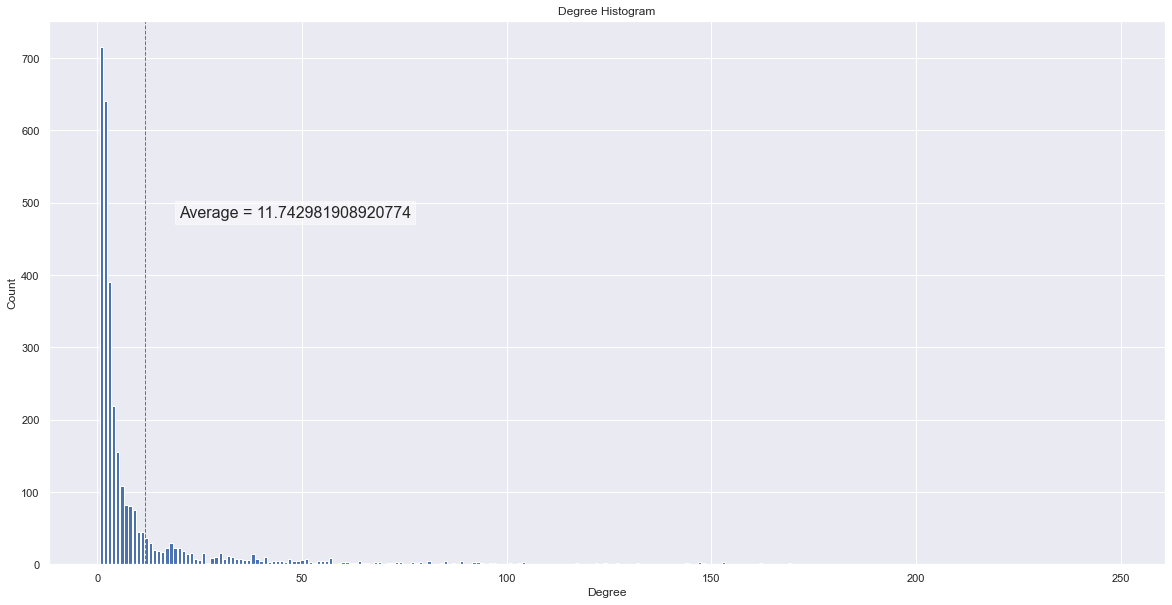

In [20]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize = (20,10))
plt.bar(deg, cnt, width=0.80, color='b')
mean = np.array(degree_sequence).mean()
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.text(20,480,'Average = {}'.format(mean),bbox=dict(facecolor='white', alpha=0.5), fontsize=16)
plt.show()

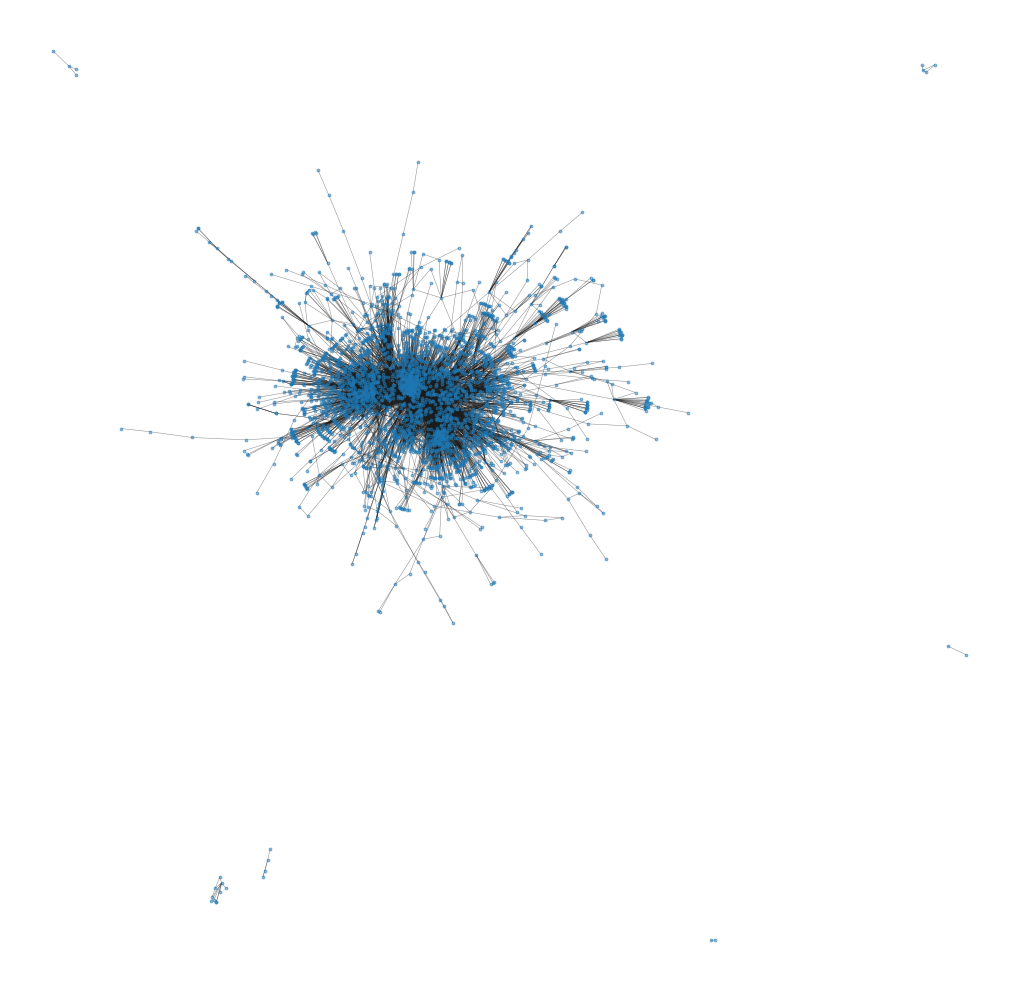

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

In [22]:
print("We can see that our graph is not connected. In fact, there are", nx.number_connected_components(G), "components in total.")
largest_cc =  max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
print("We get the largest connected component for the continuation. It contains", len(largest_cc),"nodes.")

We can see that our graph is not connected. In fact, there are 7 components in total.
We get the largest connected component for the continuation. It contains 3180 nodes.


In [23]:
print("The diameter of the graph is the length of the longest shortest path between any pair of nodes.")
print("The diameter of our graph is", nx.diameter(largest_cc))

The diameter of the graph is the length of the longest shortest path between any pair of nodes.
The diameter of our graph is 12


In [24]:
pos = {airport: (v['Longitude'], v['Latitude'])
       for airport, v in
       airports.to_dict('index').items()}

In [25]:
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]

In [26]:
labels = {iata: iata if deg[iata] >= 200 else ''
          for iata in largest_cc.nodes}

In [27]:
def display_map(graph, node_color=None):
    # Map projection
    fig, ax = plt.subplots(
        1, 1, figsize=(36, 24),
        subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()

    # Extent of continental US.
    #ax.set_extent([-128, -62, 20, 50])
    nx.draw_networkx(graph, ax=ax,
                     font_size=20,
                     alpha=.5,
                     width=.075,
                     node_size=sizes,
                     labels=labels,
                     pos=pos,
                     node_color=node_color)

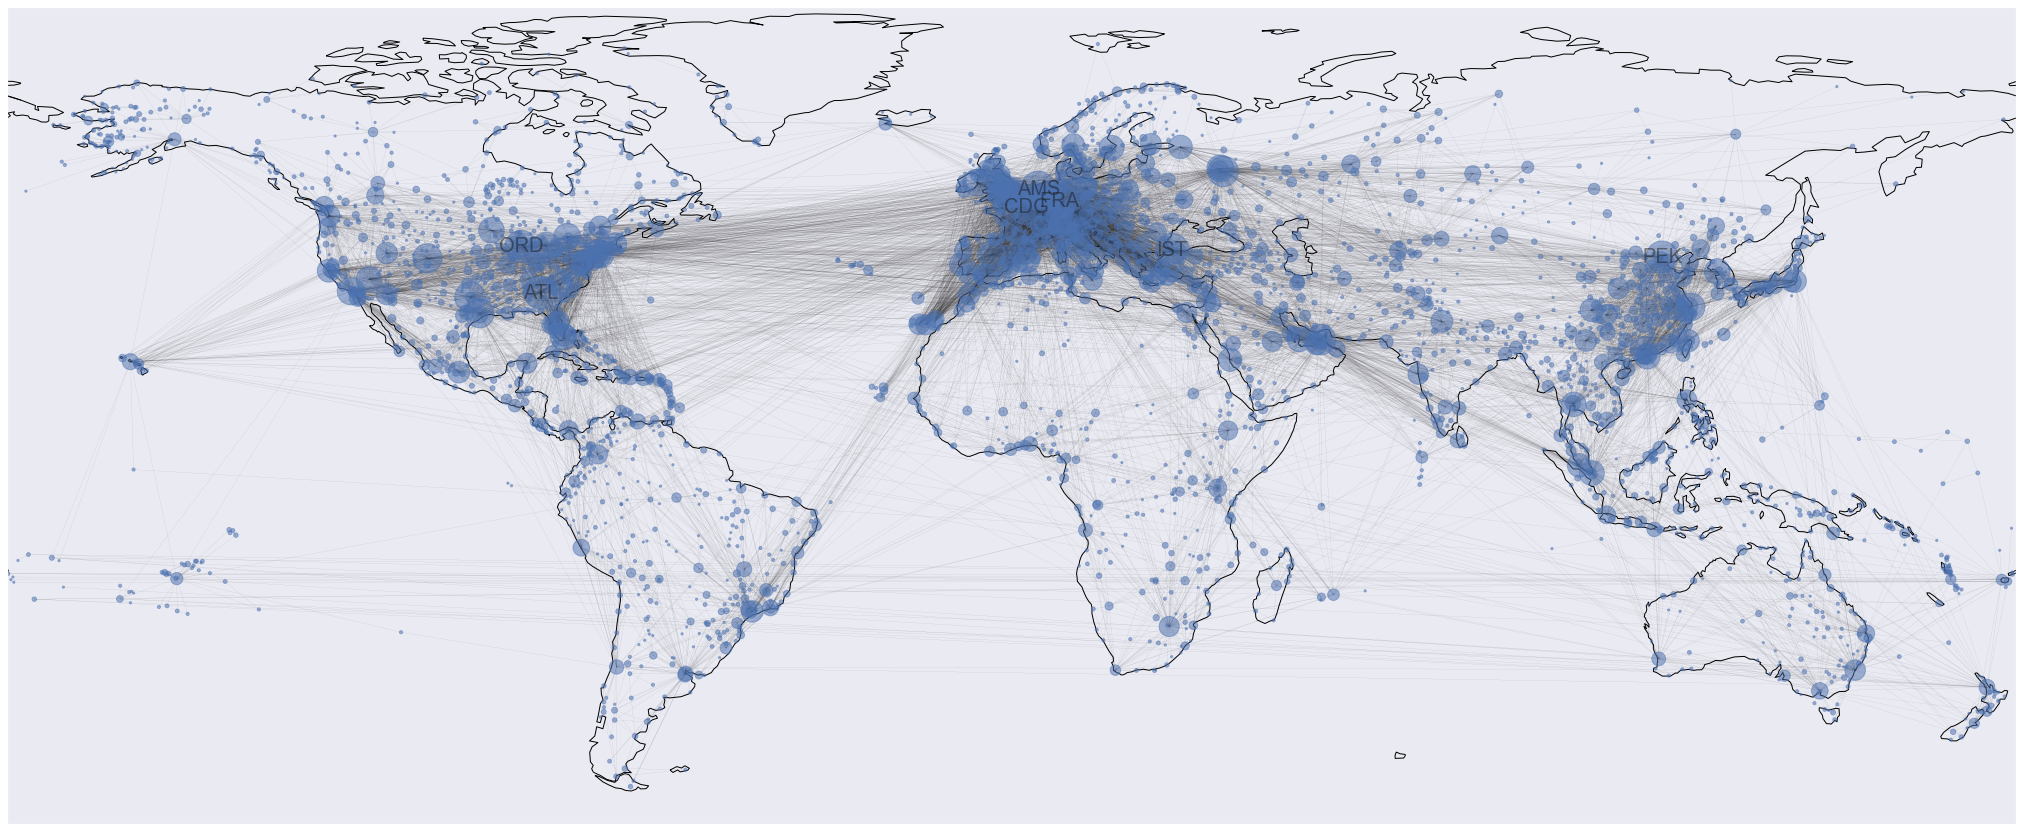

In [28]:
display_map(largest_cc)

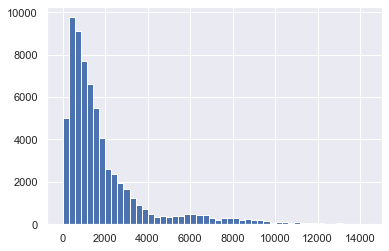

In [29]:
plt.hist(routes_clean['Distance'].values, bins = 50)
plt.show()

# Qian Chucheng

************Qian Chucheng Start form This Block************

In [ ]:
 c2 = nx.algorithms.community.greedy_modularity_communities(largest_cc)

In [137]:
size =10
cmap = plt.cm.get_cmap('gist_rainbow')
rgba = np.linspace(0.0, 1.0, num=size)
list_col=[]

for node in largest_cc.nodes:
    curr_len = len(list_col)
    for i in range(size):
        if node in c2[i]:
            list_col.append(cmap(rgba[i]))
            
    if len(list_col) == curr_len:
        list_col.append((0.5, 0.5, 0.5))

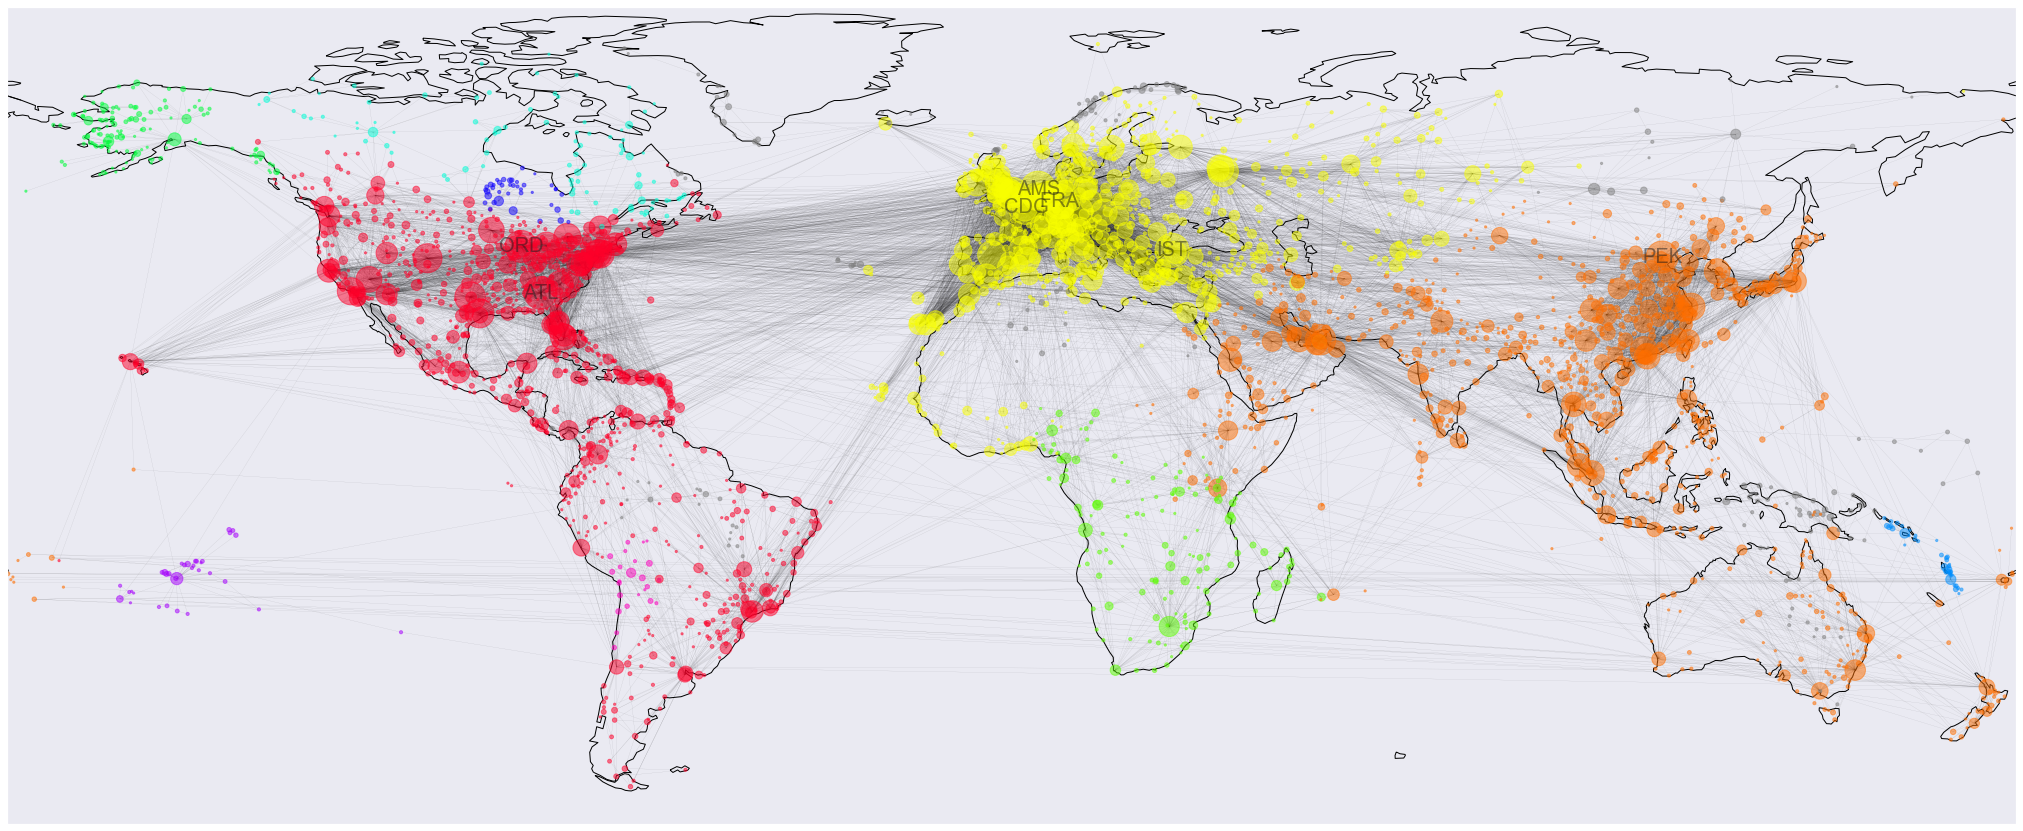

In [138]:
display_map(largest_cc, node_color=list_col)

In [98]:
nx.algorithms.community.quality.coverage(largest_cc,  c2)

0.9036118942496941

In [99]:
nx.algorithms.community.quality.modularity(largest_cc,  c2)

0.6018861173498361

In [100]:
ccc = list(c2)

In [88]:
#Helper functions
def get_NameCity(ID):
    row = airports.loc[ID]
    return row['Name'], row['City']

def plot_dict(dict_, k, name):
    

    def print_rank(l):
        for k in range(len(l)):

            a,b = get_NameCity(l[k])
            #print('{}. {}, {}'.format(k+1,a,b))
            
    
    airports, values = list(dict_.keys()), list(dict_.values())
    sort_index = list(np.argsort(values))
    airports_s = np.array(airports)[sort_index][::-1] #k highest ranked
    values_s = np.array(values)[sort_index][::-1]

    #sns.barplot(x=airports_s[:k], y=values_s[:k],palette="deep", label='small')
    
    #print('- In means of {} : Top 10 respectively are : '.format(name,k))
    print_rank(airports_s[:k])
    return list(zip(airports_s, np.array(range(len(airports_s)))+1))


In [106]:
#find key players for each sub-community

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
for com_num in range(len(c2[0:10])):
    routes_sep = routes.copy()[['Source airport', 'Destination airport', 'Distance']][0:0]
    
    for i in range(len(routes)):
        if routes['Source airport'][i] in c2[com_num] and routes['Destination airport'][i] in c2[com_num]:
            #routes_sep.append({'Source airport': routes['Source airport'][i], 'Destination airport': routes['Destination airport'][i], 'Distance': routes['Distance'][i]},ignore_index=True)
            routes_sep.loc[len(routes_sep)]= [routes['Source airport'][i], routes['Destination airport'][i], routes['Distance'][i]]
    gg=  nx.from_pandas_edgelist(routes_sep, 'Source airport', 'Destination airport', ['Distance'])
    
    betweenness = nx.betweenness_centrality(gg)
    bet_sort = plot_dict(betweenness,10,'betweenness')
    pagerank = nx.pagerank(gg)
    pr_sort = plot_dict(pagerank, 10, 'pagerank')
    degree_centrality= nx.degree_centrality(gg)
    dc_sort = plot_dict(degree_centrality, 10, 'degree_centrality')

    
    bt = pd.DataFrame(bet_sort, columns = ['Airport ID', 'Betweenness']) 
    pr = pd.DataFrame(pr_sort, columns = ['Airport ID', 'PageRank']) 
    dc = pd.DataFrame(dc_sort, columns = ['Airport ID', 'degree_centrality']) 

    dfs = [bt, pr, dc]
    df_final = reduce(lambda left,right: pd.merge(left,right,on='Airport ID'), dfs)
    df_final['Average'] = (df_final['Betweenness']+df_final['PageRank']+df_final['degree_centrality'])/3
    df_final.sort_values('Average',inplace=True)
    df_final.reset_index(drop = True,inplace=True)
    df_final['OverAll Rank'] = np.array(df_final.index)+1
    df_final.set_index('Airport ID',inplace=True)
    namecity = pd.Series(df_final.index).apply(lambda x : str('{}, {}'.format(get_NameCity(x)[0],get_NameCity(x)[1])))
    df_final.reset_index(inplace=True)
    df_final['Airport Name, City'] = namecity
    df_final.set_index('Airport ID',inplace=True)
    print('For Sub-Community',com_num+1,'Top 5 key players are')
    print(df_final.head(5))
    
    

For Sub-Community 1 Top 5 key players are
            Betweenness  PageRank  degree_centrality   Average  OverAll Rank                                 Airport Name, City
Airport ID                                                                                                                     
ATL                   2         1                  1  1.333333             1  Hartsfield Jackson Atlanta International Airpo...
DFW                   4         2                  2  2.666667             2  Dallas Fort Worth International Airport, Dalla...
DEN                   5         3                  4  4.000000             3               Denver International Airport, Denver
ORD                   7         4                  3  4.666667             4      Chicago O'Hare International Airport, Chicago
IAH                   8         5                  5  6.000000             5  George Bush Intercontinental Houston Airport, ...
For Sub-Community 2 Top 5 key players are
            Betweenn